# ConvLM

A temporal convolutional language model is trained

In [1]:
# % load_ext autoreload
# % autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch import nn

In [3]:
from lm.data import LMDataLoader
from lm.models import ConvLM, accuracy, perplexity
from lm.schedulers import OneCycle

In [4]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

Loading the data, making dataloaders

In [5]:
dict_path = Path('word2int.pickle')
with dict_path.open('rb') as file:
    d = pickle.load(file)

In [6]:
xtrain = np.load('wikitext_train_int_tokens.npy')
xval = np.load('wikitext_valtest_int_tokens.npy')

In [7]:
xtrain_tensor = torch.from_numpy(xtrain).long()
xval_tensor = torch.from_numpy(xval).long()

if device.type == 'cuda':
    xtrain_tensor = xtrain_tensor.cuda()
    xval_tensor = xval_tensor.cuda()

In [8]:
train_dataloader = LMDataLoader(xtrain_tensor, 70, 64)
val_dataloader = LMDataLoader(xval_tensor, 70, 64)

In [9]:
vocab_size = len(d)
padding_idx = d['_pad_']

In [10]:
embedding_dropout=0.1
num_blocks=3
kernel_size=2
num_layers=3

In [11]:
model = ConvLM(num_layers=num_layers, embedding_dropout=embedding_dropout, num_blocks=num_blocks, 
               vocab_size=vocab_size, kernel_size=kernel_size, padding_idx=padding_idx).cuda()

In [12]:
model

ConvLM(
  (embedding): VDEmbedding(
    (embedding): Embedding(30002, 400, padding_idx=0)
  )
  (TCNBlock_0): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(1,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 1150, kernel_size=(2,), stride=(1,), padding=(1,))
    )
    (conv3): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(1,))
    )
  )
  (TCNBlock_1): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 1150, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
    (conv3): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
  )
  (TCNBlock_2): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    )
    (conv2): WDConv(
      (co

Finally, define our losses

In [13]:
crit = nn.CrossEntropyLoss()

Now, lets find the maximum and minimum learning rates

In [14]:
optimizer = torch.optim.Adam(model.parameters())

In [15]:
starting_learning_rate = 1e-5
ending_learning_rate = 1

info = defaultdict(list)

for batch_number, batch in (enumerate(tqdm(train_dataloader))):
    
    addition = (batch_number / len(train_dataloader)) * (ending_learning_rate - starting_learning_rate)
    learning_rate = starting_learning_rate + addition
    # update the optimizer learning rates
    for g in optimizer.param_groups:
        g['lr'] = learning_rate
    info['lr'].append(learning_rate)
    # Zero the gradients of my optimizer - 'reset' it
    optimizer.zero_grad()

    x, y = batch
    pred = model(x)

    loss = crit(pred, y)
    acc = accuracy(pred, y)

    info['loss'].append(loss.item())
    info['accuracy'].append(acc)
    
    loss.backward()
    optimizer.step()

 92%|█████████▏| 471/514 [00:50<00:04,  9.26it/s]


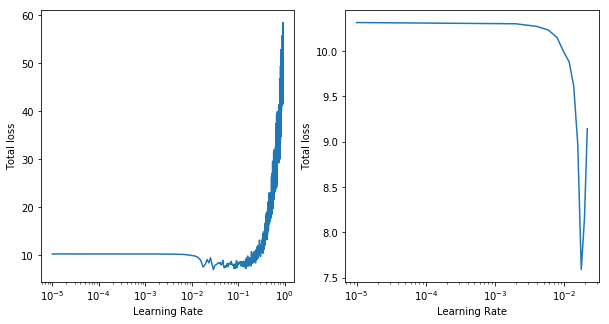

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(info['lr'], info['loss'])
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(info['lr'][:12], info['loss'][:12])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

Next, lets pretrain the embedding layers only for one epoch

In [14]:
emb_optimizer = torch.optim.Adam([pam for name, pam in model.named_parameters() if 'embedding' in name])

In [15]:
emb_scheduler = OneCycle(emb_optimizer, len(train_dataloader), upswing=0.1, downswing=0.9, min_lr=1e-5,
                         max_lr=1e-2)

In [16]:
# set the model to train
model.train()
# keep track of training scores, so they can be displayed later
train_scores = defaultdict(list)

for batch_number, batch in (enumerate(tqdm(train_dataloader))):
    # Zero the gradients of my optimizer - 'reset' it
    emb_optimizer.zero_grad()

    x, y = batch
    pred = model(x)

    loss = crit(pred, y)
    acc = accuracy(pred, y)

    train_scores['loss'].append(loss.item())
    train_scores['accuracy'].append(acc)
    train_scores['perplexity'].append(perplexity(loss))

    total_loss = loss
    total_loss.backward()
    emb_optimizer.step()
    emb_scheduler.step()

train_output_strings = []
for key, val in train_scores.items():
    mean_value = np.array(val).mean()
    train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))

if val_dataloader:
    model.eval()
    val_scores = defaultdict(list)
    with torch.no_grad():
        for batch_number, batch in enumerate(val_dataloader):
            x, y = batch
            pred = model(x)
            val_loss = crit(pred, y)
            acc = accuracy(pred, y)

            val_scores['loss'].append(val_loss)
            val_scores['accuracy'].append(acc)
            val_scores['perplexity'].append(perplexity(val_loss))

    val_output_strings = []
    for key, val in val_scores.items():
        mean_value = np.array(val).mean()
        val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
print('TRAINING: {}, {}, {}'.format(*train_output_strings))
print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

 92%|█████████▏| 472/514 [02:40<00:14,  2.94it/s]


TRAINING: loss: 8.75012, accuracy: 0.05118, perplexity: 477.37187
VALIDATION: loss: 8.130260467529297, accuracy: 0.07753, perplexity: 301.89972


Then, everything

In [17]:
optimizer = torch.optim.Adam(model.parameters())

In [18]:
scheduler = OneCycle(optimizer, len(train_dataloader), upswing=2, downswing=18, min_lr=1e-5,
                     max_lr=1e-2)

In [19]:
num_epochs = scheduler.num_epochs()

In [20]:
overall_train = defaultdict(list)
overall_val = defaultdict(list)

for epoch in range(num_epochs):
    # set the model to train
    model.train()
    # keep track of training scores, so they can be displayed later
    train_scores = defaultdict(list)
    
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()
        
        x, y = batch
        pred = model(x)
        
        loss = crit(pred, y)
        acc = accuracy(pred, y)
        
        train_scores['loss'].append(loss.item())
        train_scores['accuracy'].append(acc)
        train_scores['perplexity'].append(perplexity(loss))
        
        total_loss = loss
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_output_strings = []
    for key, val in train_scores.items():
        mean_value = np.array(val).mean()
        train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
        overall_train[key].append(mean_value)
        
    if val_dataloader:
        model.eval()
        val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in enumerate(val_dataloader):
                x, y = batch
                pred = model(x)
                val_loss = crit(pred, y)
                acc = accuracy(pred, y)
                
                val_scores['loss'].append(val_loss)
                val_scores['accuracy'].append(acc)
                val_scores['perplexity'].append(perplexity(val_loss))
                
        val_output_strings = []
        for key, val in val_scores.items():
            mean_value = np.array(val).mean()
            val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
            overall_val[key].append(mean_value)
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.78576, accuracy: 0.06526, perplexity: 238.46112
VALIDATION: loss: 7.398240089416504, accuracy: 0.0692, perplexity: 177.22494


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.52159, accuracy: 0.06973, perplexity: 194.93447
VALIDATION: loss: 7.254260063171387, accuracy: 0.06692, perplexity: 161.69307


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.45812, accuracy: 0.06792, perplexity: 186.32264
VALIDATION: loss: 7.210090160369873, accuracy: 0.07238, perplexity: 158.82756


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.37561, accuracy: 0.06916, perplexity: 176.04389
VALIDATION: loss: 7.100150108337402, accuracy: 0.07282, perplexity: 143.45009


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.33166, accuracy: 0.07011, perplexity: 169.38233
VALIDATION: loss: 7.010270118713379, accuracy: 0.07097, perplexity: 135.07738


  0%|          | 1/514 [00:00<01:39,  5.17it/s]

TRAINING: loss: 7.29698, accuracy: 0.06943, perplexity: 165.42722
VALIDATION: loss: 7.061389923095703, accuracy: 0.07385, perplexity: 142.66875


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.25115, accuracy: 0.06967, perplexity: 160.46277
VALIDATION: loss: 7.033160209655762, accuracy: 0.07234, perplexity: 140.19251


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.27158, accuracy: 0.06688, perplexity: 163.00137
VALIDATION: loss: 7.0100297927856445, accuracy: 0.07223, perplexity: 134.92942


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.1929, accuracy: 0.07128, perplexity: 153.82501
VALIDATION: loss: 6.997910022735596, accuracy: 0.07482, perplexity: 135.26363


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.22393, accuracy: 0.06811, perplexity: 157.14056
VALIDATION: loss: 7.077000141143799, accuracy: 0.06943, perplexity: 141.62924


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.22703, accuracy: 0.06666, perplexity: 160.12025
VALIDATION: loss: 7.055980205535889, accuracy: 0.08119, perplexity: 139.34022


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.17986, accuracy: 0.06892, perplexity: 151.67999
VALIDATION: loss: 7.04019021987915, accuracy: 0.06899, perplexity: 137.9728


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.2133, accuracy: 0.06542, perplexity: 155.86626
VALIDATION: loss: 6.951109886169434, accuracy: 0.06978, perplexity: 129.13653


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.16567, accuracy: 0.06905, perplexity: 151.401
VALIDATION: loss: 6.936960220336914, accuracy: 0.06746, perplexity: 127.58035


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.1747, accuracy: 0.06653, perplexity: 151.13826
VALIDATION: loss: 6.930930137634277, accuracy: 0.07242, perplexity: 126.87478


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.1479, accuracy: 0.06849, perplexity: 149.40525
VALIDATION: loss: 6.9286298751831055, accuracy: 0.07429, perplexity: 126.16701


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.14078, accuracy: 0.06761, perplexity: 147.95229
VALIDATION: loss: 6.919990062713623, accuracy: 0.06922, perplexity: 128.56475


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.11955, accuracy: 0.06688, perplexity: 145.86096
VALIDATION: loss: 6.871319770812988, accuracy: 0.07491, perplexity: 121.97034


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.13449, accuracy: 0.06774, perplexity: 147.25866
VALIDATION: loss: 6.989620208740234, accuracy: 0.06562, perplexity: 133.64206


 93%|█████████▎| 477/514 [02:36<00:12,  3.05it/s]


TRAINING: loss: 7.17454, accuracy: 0.06502, perplexity: 151.78928
VALIDATION: loss: 6.907800197601318, accuracy: 0.071, perplexity: 125.24823


In [21]:
model_information = {'state_dict': model.state_dict(),
                     'val_acc': overall_val['accuracy'],
                      'val_loss': overall_val['loss'],
                      'train_acc': overall_train['accuracy'],
                    'train_loss': overall_train['loss'],
                    'num_blocks': num_blocks,
                    'embedding_dropout': embedding_dropout,
                    'kernel_size': kernel_size,
                    'num_layers': num_layers}
torch.save(model_information, 'ConvLM_B3_L3_K2.pth.tar')

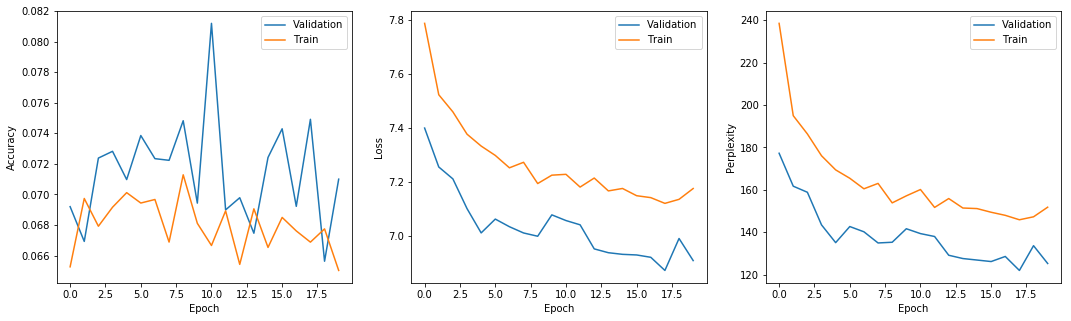

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# First, lets plot accuracy
axes[0].plot(range(len(overall_val['accuracy'])), overall_val['accuracy'], label='Validation')
axes[0].plot(range(len(overall_train['accuracy'])), overall_train['accuracy'], label='Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# then, loss
axes[1].plot(range(len(overall_val['loss'])), overall_val['loss'], label='Validation')
axes[1].plot(range(len(overall_train['loss'])), overall_train['loss'], label='Train')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# finally, perplexity
axes[2].plot(range(len(overall_val['perplexity'])), overall_val['perplexity'], label='Validation')
axes[2].plot(range(len(overall_train['perplexity'])), overall_train['perplexity'], label='Train')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Perplexity')
axes[2].legend()